In [444]:
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import psycopg2
import textatistic
import seaborn as sns
import requests
import math
from bs4 import BeautifulSoup
from pandas import DataFrame
import string
import textblob
import re
import random
from collections import Counter
from wordcloud import *
from nltk.corpus import stopwords
from subprocess import check_output
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
matplotlib.style.use('ggplot') 
plt.style.use('fivethirtyeight')

py.offline.init_notebook_mode()

# Median weekly earnings of full-time wage and salary workers by detailed occupation and sex.

* Occupation: Job title as given from BLS. Industry summaries are given in ALL CAPS.

* All_workers: Number of workers male and female, in thousands.

* All_weekly: Median weekly income including male and female workers, in USD.

* M_workers: Number of male workers, in thousands.

* M_weekly: Median weekly income for male workers, in USD.

* F_workers: Number of female workers, in thousands.

* F_weekly: Median weekly income for female workers, in USD.

## 535 different occupations
## Source: Bureau of Labor Statistics
## As of January 2015.


# Questions
* Is the ratio of wages normally distributed?
* Which jobs/sectors have the smallest gap between wages?
* What are the percentages of women in the highest paying jobs?

In [445]:
df = pd.read_csv('/home/students/carpco02/inc_occ_gender.csv')


In [446]:
df

Occupation  All_workers  \
0                                      ALL OCCUPATIONS       109080   
1                                           MANAGEMENT        12480   
2                                     Chief executives         1046   
3                      General and operations managers          823   
4                                          Legislators            8   
5                  Advertising and promotions managers           55   
6                         Marketing and sales managers          948   
7            Public relations and fundraising managers           59   
8                     Administrative services managers          170   
9            Computer and information systems managers          636   
10                                  Financial managers         1124   
11                  Compensation and benefits managers           23   
12                            Human resources managers          254   
13                   Training and development managers           37   
14                      Industrial production managers          267   
15                                 Purchasing managers          193   
16   Transportation, storage, and distribution mana...          276   
17   Farmers, ranchers, and other agricultural mana...          129   
18                               Construction managers          471   
19                            Education administrators          778   
20              Architectural and engineering managers          110   
21                               Food service managers          763   
22                            Funeral service managers           13   
23                                     Gaming managers           19   
24                                    Lodging managers          123   
25                Medical and health services managers          592   
26                           Natural sciences managers           24   
27                Postmasters and mail superintendents           20   
28   Property, real estate, and community associati...          401   
29               Social and community service managers          305   
..                                                 ...          ...   
528             Driver/sales workers and truck drivers         2687   
529                        Taxi drivers and chauffeurs          253   
530                 Motor vehicle operators, all other           21   
531                 Locomotive engineers and operators           44   
532       Railroad brake, signal, and switch operators            5   
533                Railroad conductors and yardmasters           55   
534  Subway, streetcar, and other rail transportati...           15   
535                          Sailors and marine oilers           10   
536               Ship and boat captains and operators           29   
537                                     Ship engineers            5   
538                            Bridge and lock tenders            4   
539                             Parking lot attendants           57   
540       Automotive and watercraft service attendants           63   
541                          Transportation inspectors           21   
542  Transportation attendants, except flight atten...           17   
543                       Other transportation workers           39   
544                     Conveyor operators and tenders            7   
545                          Crane and tower operators           75   
546  Dredge, excavating, and loading machine operators           25   
547                          Hoist and winch operators            5   
548             Industrial truck and tractor operators          579   
549                 Cleaners of vehicles and equipment          222   
550  Laborers and freight, stock, and material move...         1433   
551                     Machine feeders and offbearers           30   
552                        Packers and packagers, hand          385 

# Create a few useful columns and deal with 'Na' values in data...

In [447]:

df = df[~(df.M_weekly == 'Na')]
df = df[~(df.F_weekly == 'Na')]

df['All_weekly'] = df.All_weekly.apply(lambda x: int(x))
df['All_workers'] = df.All_workers.apply(lambda x: int(x))

df['M_workers'] = df.M_workers.apply(lambda x: int(x))
df['F_workers'] = df.F_workers.apply(lambda x: int(x))

df['M_weekly'] = df.M_weekly.apply(lambda x: int(x))
df['F_weekly'] = df.F_weekly.apply(lambda x: int(x))


df['M_share'] = df.M_workers/df.All_workers 
df['F_share'] = df.F_workers/df.All_workers 

df['Mean_weekly'] = (df.M_weekly + df.F_weekly)/2
df['Gap'] = df.M_weekly - df.F_weekly

df['Ratio_of_Fwe_to_Mwe'] = df.F_weekly/df.M_weekly
df['Ratio_of_Fwo_toMwo'] = df.F_workers/df.M_workers



# Create distribution of females to male wages to check normal distribution

0.82629201188418389

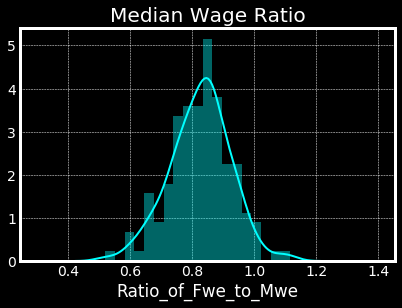

In [455]:
sns.distplot(df.Ratio_of_Fwe_to_Mwe, bins = np.linspace(0.3,1.4,36),color = 'cyan')
plt.title('Median Wage Ratio')
matplotlib.style.use('dark_background') 

np.mean(df.Ratio_of_Fwe_to_Mwe)

# This mean distribution of the ratios of female wages to male wages indicates that this group of women from this sample will on average receive .83 of whatever a male worker would recieve 

(0, 1.2)

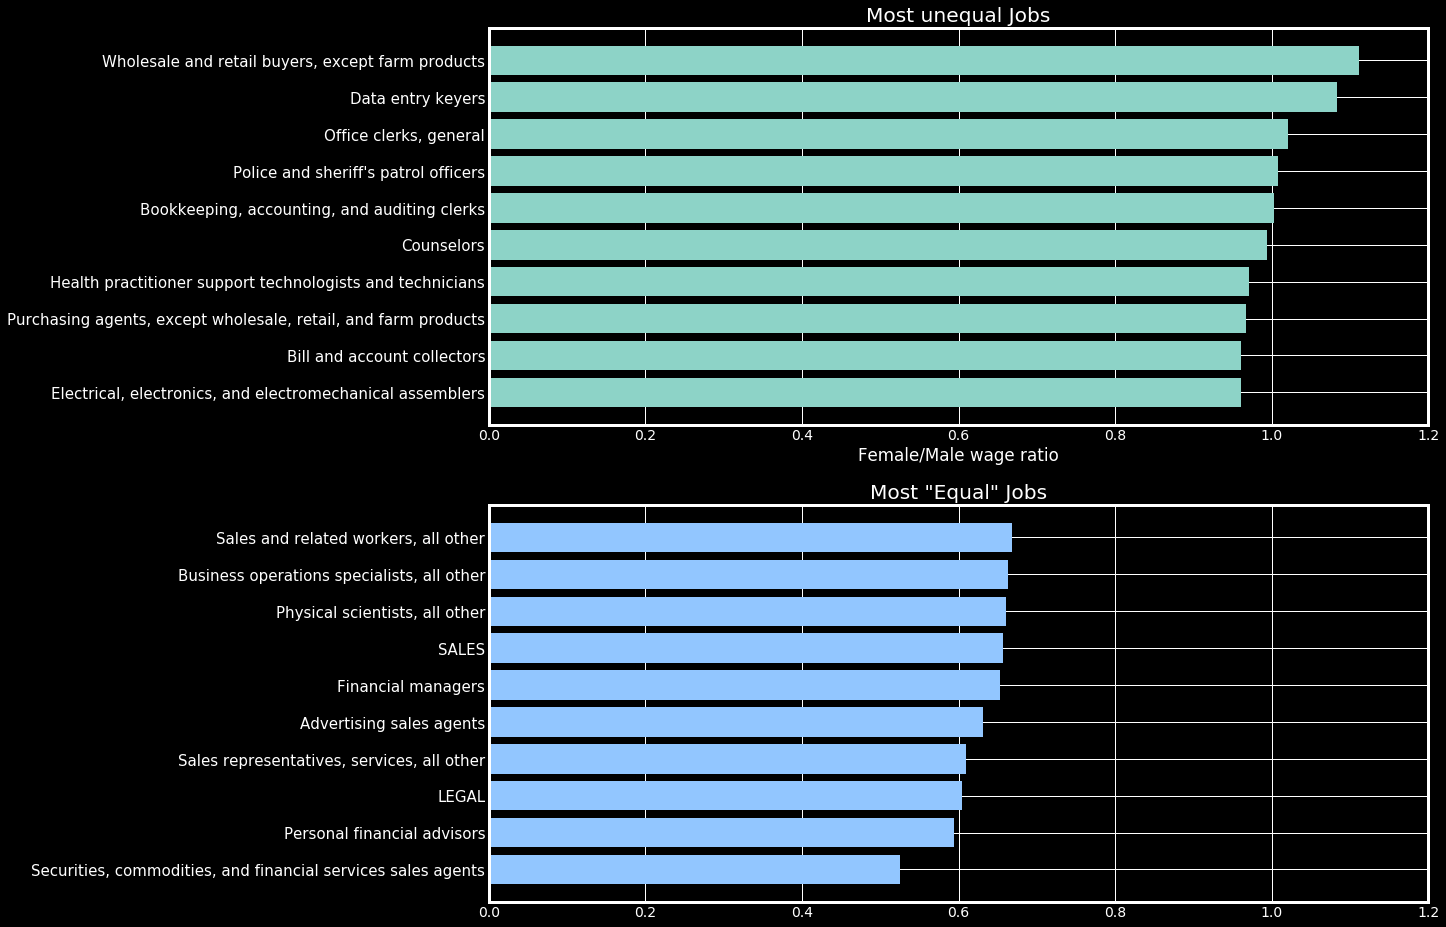

In [449]:
sorted_df = df.sort_values(['Ratio_of_Fwe_to_Mwe'], ascending = [True])

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
plt.style.use(['dark_background','seaborn-pastel'])
plt.barh(range(10),sorted_df.tail(10).Ratio_of_Fwe_to_Mwe)
plt.yticks(range(10),sorted_df.tail(10).Occupation, fontsize = 15)
plt.title('Most unequal Jobs')
plt.xlim([0,1.2])
plt.xlabel('Female/Male wage ratio')
plt.subplot(2,1,2)
plt.barh(range(10),sorted_df.head(10).Ratio_of_Fwe_to_Mwe)
plt.yticks(range(10),sorted_df.head(10).Occupation, fontsize = 15)
plt.title('Most "Equal" Jobs')
plt.xlim([0,1.2])



Text(0.5,0,'Share of Women')

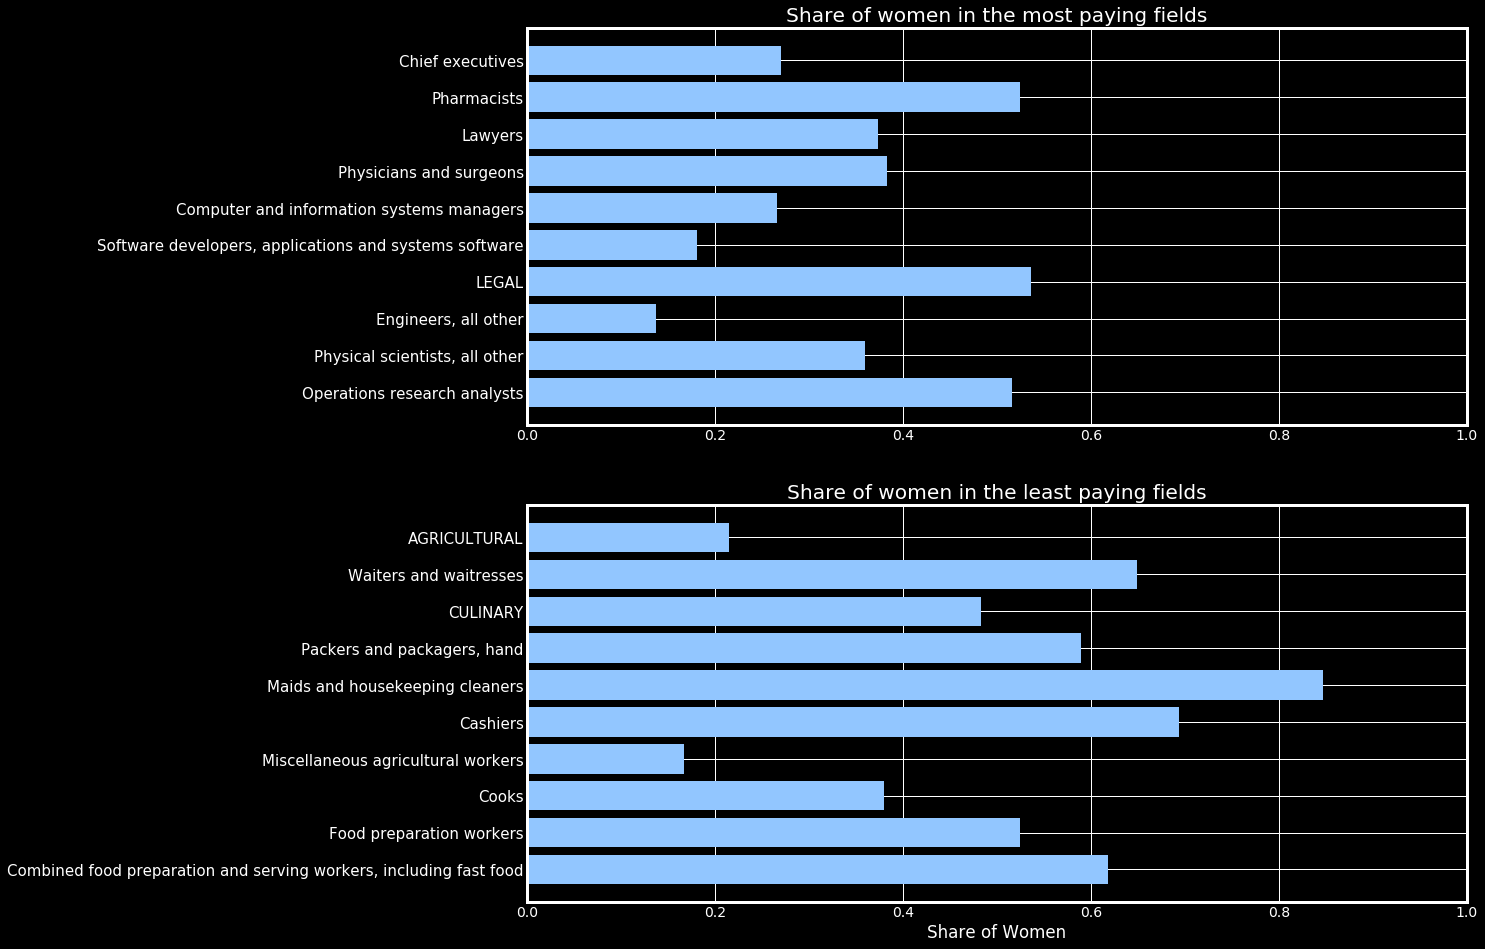

In [450]:
sorted_df = df.sort_values(['Mean_weekly'], ascending = [True])

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
plt.style.use(['dark_background','seaborn-pastel'])
plt.barh(range(10),sorted_df.tail(10).F_share)
plt.yticks(range(10),sorted_df.tail(10).Occupation, fontsize = 15)
plt.xlim([0,1])
plt.title('Share of women in the most paying fields')
plt.subplot(2,1,2)
plt.style.use(['dark_background','seaborn-pastel'])
plt.barh(range(10),sorted_df.head(10).F_share)
plt.yticks(range(10),sorted_df.head(10).Occupation, fontsize = 15)
plt.xlim([0,1])
plt.title('Share of women in the least paying fields')
plt.xlabel('Share of Women')


Text(0.5,1,'Least paying fields')

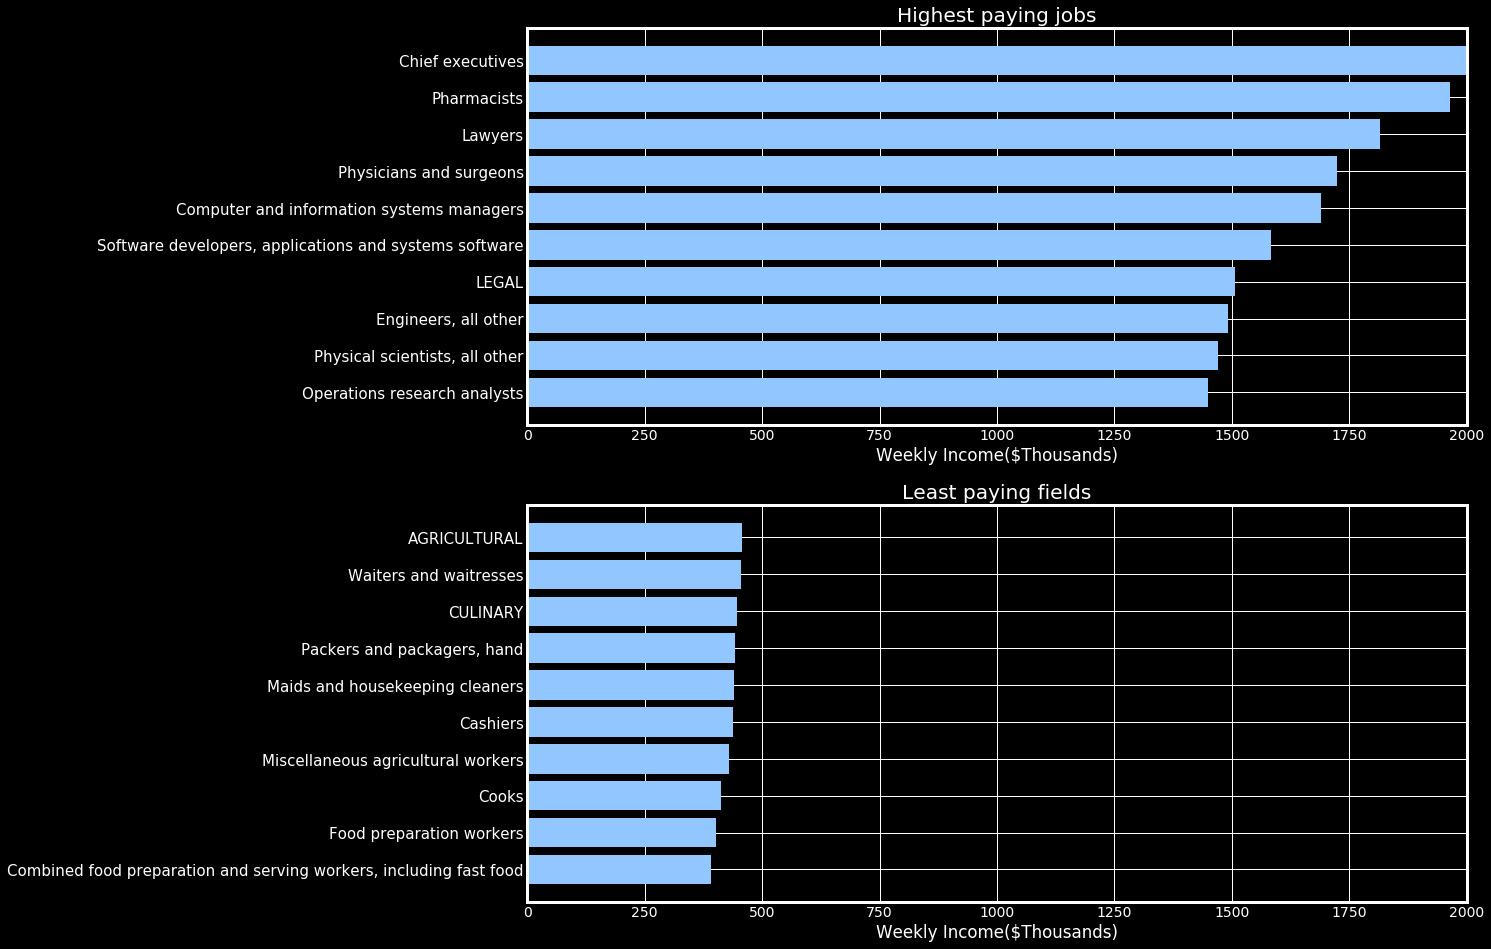

In [451]:
plt.figure(figsize = (15,15))

plt.subplot(2,1,1)
plt.barh(range(10),sorted_df.tail(10).Mean_weekly)
plt.yticks(range(10),sorted_df.tail(10).Occupation, fontsize = 15)
plt.xlim([0,2000])
plt.xlabel('Weekly Income($Thousands)')
plt.title('Highest paying jobs')

plt.subplot(2,1,2)
plt.style.use('fivethirtyeight')
plt.barh(range(10),sorted_df.head(10).Mean_weekly)
plt.yticks(range(10),sorted_df.head(10).Occupation, fontsize = 15)
plt.xlim([0,2000])
plt.xlabel('Weekly Income($Thousands)')
plt.title('Least paying fields')

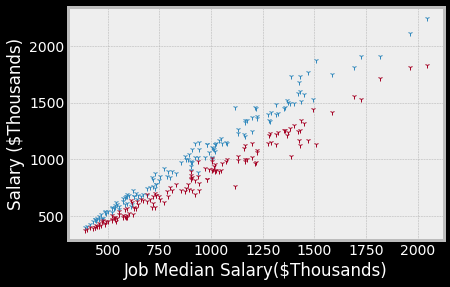

In [452]:
plt.style.use(['dark_background','bmh'])

plt.xlabel('Job Median Salary($Thousands)')
plt.ylabel('Salary ($Thousands)')
plt.plot(df.Mean_weekly,df.M_weekly,'1')
plt.plot(df.Mean_weekly,df.F_weekly,'1')
plt.show()

# After the results of our mean ratio distribution, the scatterplot for job median salary compared to male and female median salaries for a job give us two clear groups.

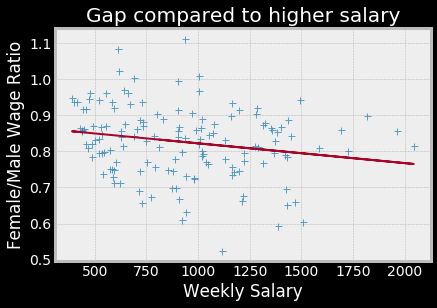

In [453]:
plt.style.use('bmh')
plt.plot(df.Mean_weekly, df.Ratio_of_Fwe_to_Mwe,'+',markersize = 7, alpha = 0.8)
plt.title('Gap compared to higher salary')
plt.xlabel('Weekly Salary')
plt.ylabel('Female/Male Wage Ratio')
x = df.Mean_weekly
y = df.Ratio_of_Fwe_to_Mwe
fn = np.polyfit(x,y,1)
fit_fn = np.poly1d(fn) 
plt.plot(x,fit_fn(x))